# Alma Mater Studiorum - University of Bologna
## Fundamentals of Artificial Intelligence and Knowledge Representation (Mod. 3)

**Authors:** Mauro Dore (mauro.dore@studio.unibo.it), Leonardo Monti - 0001057801 (leonardo.monti3@studio.unibo.it)

**Notebook Title:** Bayesian Networks for Heart Failure Prediction

---

## Introduction

Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Heart failure is a complex clinical condition and a common event caused by CVDs. Given the high incidence and mortality rates, early detection and effective management of at-risk patients are critically important.

In this context, Artificial Intelligence and Knowledge Representation techniques offer powerful tools for analyzing complex clinical data and supporting decision-making processes. This notebook focuses on the application of **Bayesian Networks**, a probabilistic graphical model that excels at handling uncertainty and modeling causal (or dependency) relationships between different variables.

## Objective


## Dataset

The dataset used in this study is the "Heart Failure Prediction" dataset, publicly available on Kaggle. It contains 918 observations and 11 relevant clinical attributes, collected from various sources, which can be used to predict heart disease (the target variable `HeartDisease`). Features include demographic data (Age, Sex), symptoms (ChestPainType), clinical measurements (RestingBP, Cholesterol, FastingBS, RestingECG, MaxHR), and stress test results (ExerciseAngina, Oldpeak, ST_Slope).

**Dataset Reference:** https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

---


In [39]:
from utils import *

random_state = 21

### Data import and conversion to numeric

In [40]:
# Read the data and print a sample
cwd = pathlib.Path.cwd()
project_dir = cwd.parent
data_path = pathlib.Path.joinpath(project_dir, 'data/heart.csv')

df = pd.read_csv(data_path)
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [41]:
# Check for nan values
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

### Nulls in disguise
Some "Cholesterol" values are reported as 0, this is evidently a missing values that was filled with 0 <br>
since such value of cholesterol is not compatible with human life and in some situations, like medical emergencies, <br>
it's not possible or not useful to measure the level of cholesterol of a patient. <br>
We used the median of the non zero values to fill the missing cholesterol records. <br> <br>
Some "Oldpeak" values are reported as negative, althought the definition of Oldpeak is not always the same, such values <br>
are most likely missing values. <br>
We used 0 to fill the missing records of Oldpeak.

In [42]:
# Check for duplicate values
print("Number of duplicates: " + str(df.duplicated().sum()))

Number of duplicates: 0


In [43]:
# Determine numerical features and categorical features

data = df.copy()

col = list(data.columns)
categorical_features = []
numerical_features = []
for i in col:
    # The number 4 is empirically decided by reading the data card
    if len(data[i].unique()) > 4:
        numerical_features.append(i)
    else:
        categorical_features.append(i)

print('Categorical Features :',*categorical_features)
print('Numerical Features :',*numerical_features)

Categorical Features : Sex ChestPainType FastingBS RestingECG ExerciseAngina ST_Slope HeartDisease
Numerical Features : Age RestingBP Cholesterol MaxHR Oldpeak


In [44]:
data.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [45]:
# Encode data to numeric data type
VERBOSE = True

lb = LabelEncoder()
objList = data.select_dtypes(include="object").columns

for obj in objList:
    print(f"\n======== {obj} ========")
    unique_values = data[obj].unique()

    if VERBOSE:
        # Print unique values before encoding
        print("Before encoding:",end="  ")
        print(unique_values,end="\n\n")
    
    # Encode object values to numeric type
    data[obj] = lb.fit_transform(data[obj].astype(str))

    # Print the mapping from origial object values to encoded numerical values
    print("MAPPING of the encoding:")
    encoded_values = lb.transform(lb.classes_)
    for original_value, encoded_value in zip(lb.classes_,encoded_values):
        print(f"'{original_value}' → {encoded_value}")
    
    if VERBOSE:
        # Print unique values after encoding
        print("\nAfter encoding:",end="  ")
        print(data[obj].unique())
    
    print(f"==========================")


======== Sex ========
Before encoding:  ['M' 'F']

MAPPING of the encoding:
'F' → 0
'M' → 1

After encoding:  [1 0]

======== ChestPainType ========
Before encoding:  ['ATA' 'NAP' 'ASY' 'TA']

MAPPING of the encoding:
'ASY' → 0
'ATA' → 1
'NAP' → 2
'TA' → 3

After encoding:  [1 2 0 3]

======== RestingECG ========
Before encoding:  ['Normal' 'ST' 'LVH']

MAPPING of the encoding:
'LVH' → 0
'Normal' → 1
'ST' → 2

After encoding:  [1 2 0]

======== ExerciseAngina ========
Before encoding:  ['N' 'Y']

MAPPING of the encoding:
'N' → 0
'Y' → 1

After encoding:  [0 1]

======== ST_Slope ========
Before encoding:  ['Up' 'Flat' 'Down']

MAPPING of the encoding:
'Down' → 0
'Flat' → 1
'Up' → 2

After encoding:  [2 1 0]


In [46]:
data.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

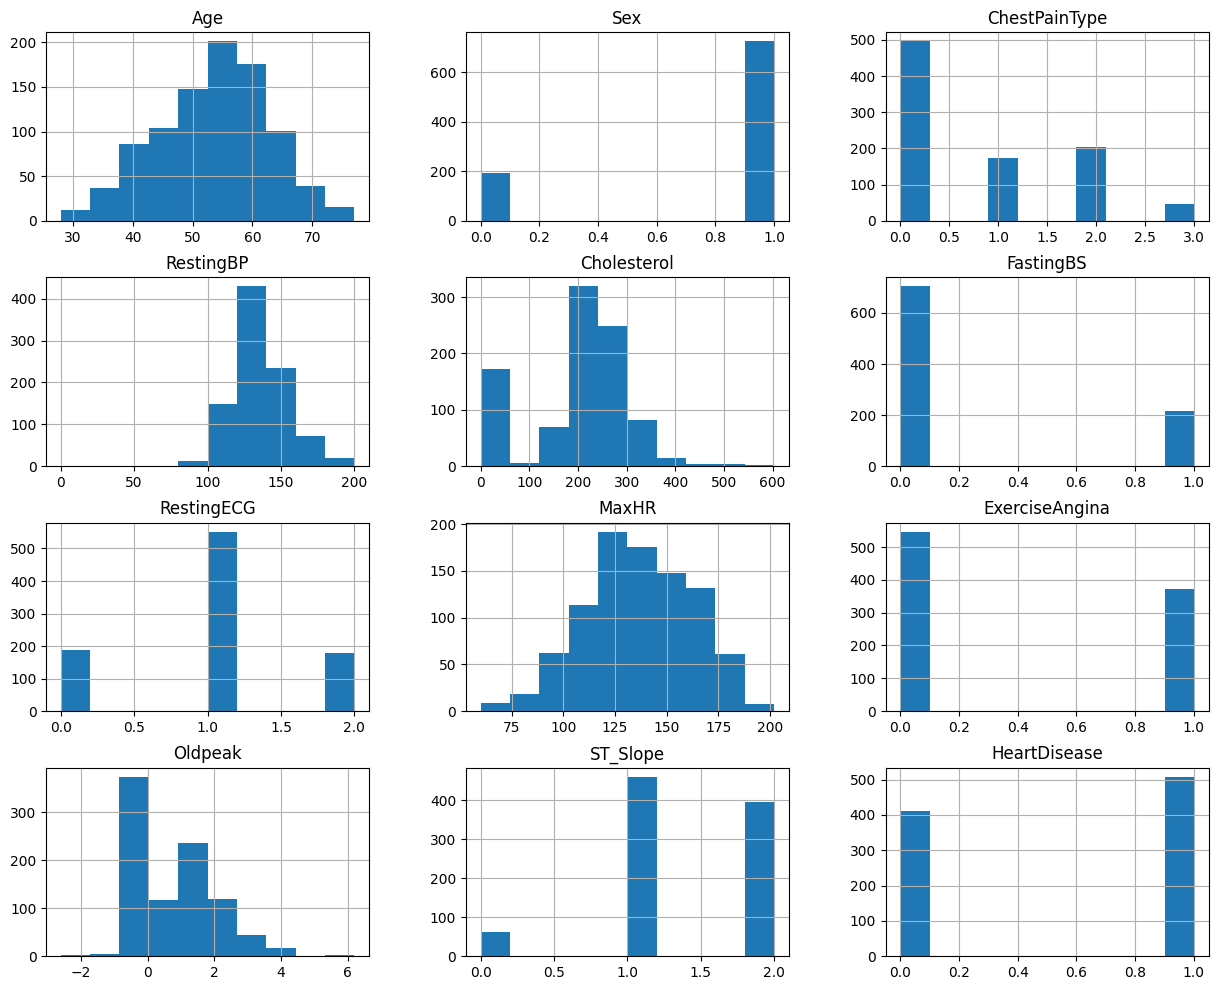

In [47]:
#Having converted everything to numeric we can plot the counts of the values
data.hist(figsize=(15,12));

### Binning of the numerical data and missing data imputation

In [48]:
# Converting numeric columns to bins
labels = [0, 1, 2]

# --- 1. Categorize Age ---
# Bins for <44, 45-60, >60 
# Motivation: it is a common division in medical literature
age_bins = [-float('inf'), 44, 60, float('inf')]

data['Age_Category'] = pd.cut(data['Age'], bins=age_bins, labels=labels, right=True)

print(data[['Age', 'Age_Category']].head())
print("- " * 20)

# --- 2. Categorize RestingBP ---
# Bins for <120, 120-139, >=140
# Motivation: it's likely systolic pressure, the division is according to the American Heart Association
bp_bins = [-np.inf, 119, 139, np.inf] 

data['RestingBP_Category'] = pd.cut(data['RestingBP'], bins=bp_bins, labels=labels, right=True)

print(data[['RestingBP', 'RestingBP_Category']].head())
print("- " * 20)

# --- 3. Categorize Cholesterol ---
# The 0 cholesterols are nulls in disguise: imputation with the median of the non 0 values 
chol_median = data.loc[data['Cholesterol'] > 0, 'Cholesterol'].median()
data.loc[data['Cholesterol'] == 0, 'Cholesterol'] = chol_median

# Bins for 0, 1-199, 200-239, >=240
# Motivation: desirable, borderline high, high, cholesterol levels according to the National Cholesterol Education Program
chol_bins = [1, 199, 239, np.inf]

data['Cholesterol_Category'] = pd.cut(data['Cholesterol'], bins=chol_bins, labels=labels, right=True)
print(data[['Cholesterol', 'Cholesterol_Category']].head())
print("- " * 20)

# --- 4. Categorize MaxHR ---
# In general the maximum heart rate is computed as 220-AGE so we compare that with the real heart rate
# Then we cut it in 3 bins: low, normal, high

data['MaxHR'] = df['MaxHR'] - (220 - df['Age'])
hr_bins = [-np.inf, -10, 10, np.inf] 
data['MaxHR_Category'] = pd.cut(data['MaxHR'], bins=hr_bins, labels=labels, right=True)

#TODO remove 
# data['MaxHR_Category'] = pd.qcut(data['MaxHR'], q=3, labels=labels, duplicates='drop')

print(data[['MaxHR', 'MaxHR_Category']].head())
print("- " * 20)

# --- 5. Categorize Oldpeak ---
# Bins for <1.0, 1.0-2.5, >2.5
# Oldpeak is a value related to the ECG signal
# The negative Oldpeaks are nulls in disguise: imputation with 0
oldpeak_bins = [-np.inf, 0.99, 2.5, np.inf] 
data.loc[data['Oldpeak'] < 0, 'Oldpeak'] = 0


data['Oldpeak_Category'] = pd.cut(data['Oldpeak'], bins=oldpeak_bins, labels=labels, right=True)

print(data[['Oldpeak', 'Oldpeak_Category']].head())

data.drop(numerical_features, axis=1, inplace=True)

   Age Age_Category
0   40            0
1   49            1
2   37            0
3   48            1
4   54            1
- - - - - - - - - - - - - - - - - - - - 
   RestingBP RestingBP_Category
0        140                  2
1        160                  2
2        130                  1
3        138                  1
4        150                  2
- - - - - - - - - - - - - - - - - - - - 
   Cholesterol Cholesterol_Category
0          289                    2
1          180                    0
2          283                    2
3          214                    1
4          195                    0
- - - - - - - - - - - - - - - - - - - - 
   MaxHR MaxHR_Category
0     -8              1
1    -15              0
2    -85              0
3    -64              0
4    -44              0
- - - - - - - - - - - - - - - - - - - - 
   Oldpeak Oldpeak_Category
0      0.0                0
1      1.0                1
2      0.0                0
3      1.5                1
4      0.0              

In [49]:
#df.iloc[:, :-1].describe().T.sort_values(by='std' , ascending = False)
data.describe(include='all')

,Sex,ChestPainType,FastingBS,RestingECG,ExerciseAngina,ST_Slope,HeartDisease,Age_Category,RestingBP_Category,Cholesterol_Category,MaxHR_Category,Oldpeak_Category
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.0,918.0,918.0,918.0,918.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0,3.0,3.0
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,519.0,430.0,409.0,714.0,499.0
mean,0.789760,0.781046,0.233115,0.989107,0.404139,1.361656,0.553377,NaN,NaN,NaN,NaN,NaN
std,0.407701,0.956519,0.423046,0.631671,0.490992,0.607056,0.497414,NaN,NaN,NaN,NaN,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
25%,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN
50%,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN
75%,1.000000,2.000000,0.000000,1.000000,1.000000,2.000000,1.000000,NaN,NaN,NaN,NaN,NaN


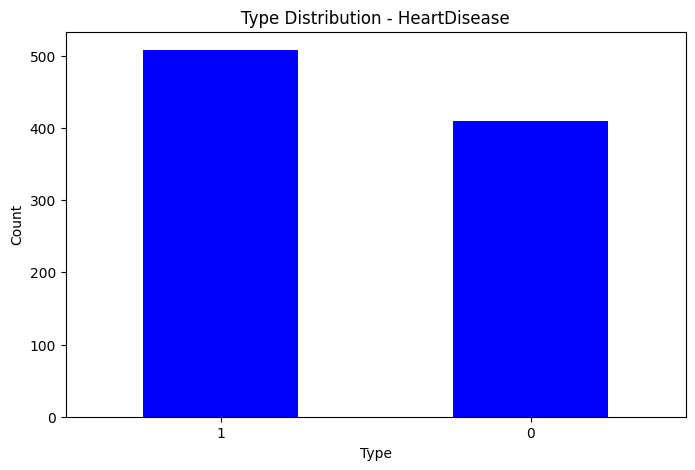

In [50]:
type_counts = data['HeartDisease'].value_counts()

# Create a bar plot for the type distribution
plt.figure(figsize=(8, 5))
type_counts.plot(kind='bar', color='blue')
plt.title('Type Distribution - HeartDisease')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

### Study of the correlations between features and HeartDisease

In [51]:
hd_corr = data.corr()["HeartDisease"].sort_values(ascending=False)
print(hd_corr)
#[1: heart disease, 0: Normal]

HeartDisease            1.000000
ExerciseAngina          0.494282
Oldpeak_Category        0.423730
Sex                     0.305445
FastingBS               0.267291
Age_Category            0.263913
RestingBP_Category      0.077988
RestingECG              0.057384
Cholesterol_Category    0.043187
MaxHR_Category         -0.249425
ChestPainType          -0.386828
ST_Slope               -0.558771
Name: HeartDisease, dtype: float64


/tmp/ipykernel_145278/2297972622.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  corr.append(hd_corr[i])


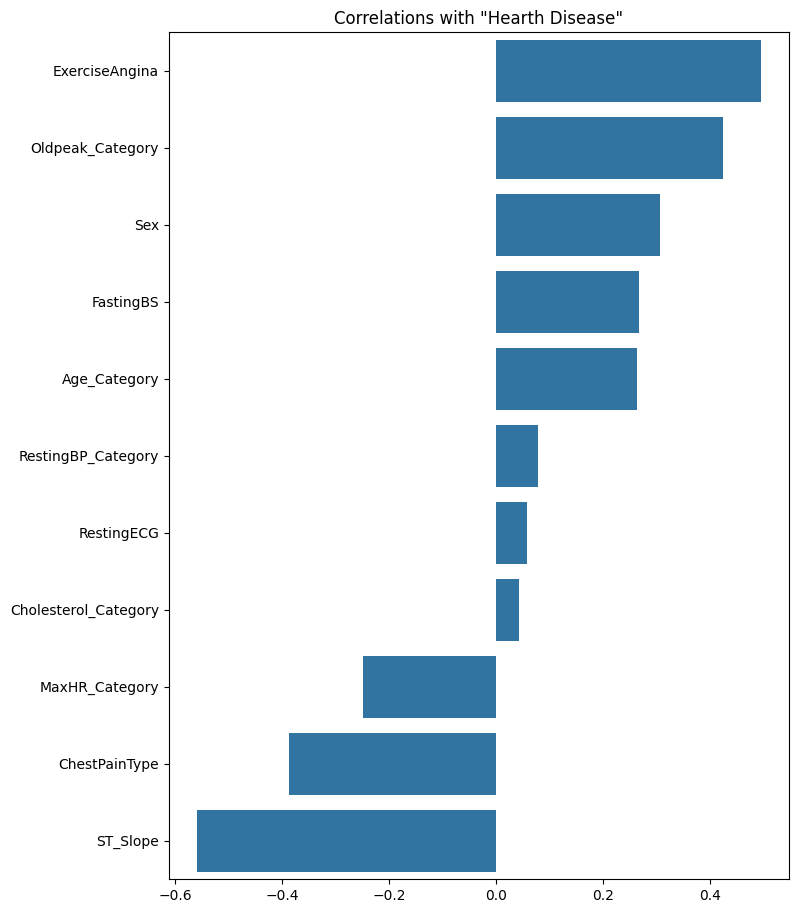

In [52]:
# Correlation of features with HeartDisease

limit = -1.0

indices = hd_corr.index
labels = []
corr = []
for i in range(1, len(indices)):
    if hd_corr[indices[i]]>limit:
        labels.append(indices[i])
        corr.append(hd_corr[i])


fig, ax = plt.subplots(figsize=(8,11))
sns.barplot(x=corr, y=labels, ax=ax)
plt.title('Correlations with "Hearth Disease"')
plt.show()


In [53]:
# Train test split
target_variable = 'HeartDisease' 
X = data.drop(columns=[target_variable])
y = data[target_variable]

X_train, X_test, y_train, y_test  = train_test_split(X, y, random_state=random_state, train_size=0.80)

train_data = pd.concat([X_train, y_train], axis=1)

### Model Construction and visualization

The graph is acyclic: True


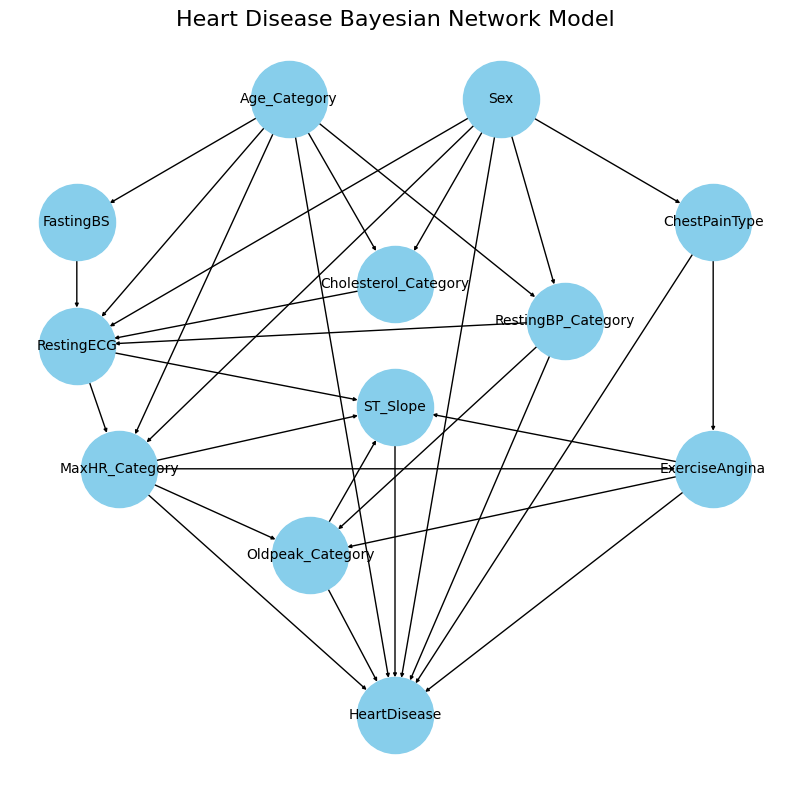

In [54]:
# Define the "Custom" Bayesian Network structure

heart_disease_model = BayesianNetwork([
    ('Age_Category', 'RestingBP_Category'), ('Age_Category', 'Cholesterol_Category'), ('Age_Category', 'MaxHR_Category'),
    ('Age_Category', 'RestingECG'), ('Age_Category', 'FastingBS'), ('Age_Category', 'HeartDisease'), 
    ('Sex', 'Cholesterol_Category'),('Sex', 'MaxHR_Category'), ('Sex', 'RestingECG'),  ('Sex', 'RestingBP_Category'), ('Sex', 'ChestPainType'), ('Sex', 'HeartDisease'),
    ('FastingBS', 'RestingECG'),
    ('Cholesterol_Category', 'RestingECG'),
    ('RestingBP_Category', 'RestingECG'), ('RestingBP_Category', 'Oldpeak_Category'), ('RestingBP_Category', 'HeartDisease'),
    ('RestingECG', 'ST_Slope'), ('RestingECG', 'MaxHR_Category'),
    ('MaxHR_Category', 'ST_Slope'), ('MaxHR_Category', 'ExerciseAngina'), ('MaxHR_Category', 'Oldpeak_Category'), ('MaxHR_Category', 'HeartDisease'), 
    ('ChestPainType', 'ExerciseAngina'), ('ChestPainType', 'HeartDisease'),
    ('ExerciseAngina', 'ST_Slope'), ('ExerciseAngina', 'Oldpeak_Category'), ('ExerciseAngina', 'HeartDisease'),
    ('Oldpeak_Category', 'ST_Slope'), ('Oldpeak_Category', 'HeartDisease'),
    ('ST_Slope', 'HeartDisease')
])

pos = {'Age_Category': [0.75, -0.5], 'Sex': [1.25, -0.5],
       'FastingBS': [0.25, -1.], 'Cholesterol_Category': [1., -1.25], 'ChestPainType': [1.75,  -1],
       'RestingBP_Category': [1.40, -1.40], 'RestingECG': [0.25, -1.5],
       'MaxHR_Category': [0.35,  -2],
       'ExerciseAngina': [1.75, -2], 'Oldpeak_Category': [0.80, -2.35], 'ST_Slope': [1.,  -1.75], 
       'HeartDisease': [1, -3]}

is_acyclic = nx.is_directed_acyclic_graph(heart_disease_model)
print(f"The graph is acyclic: {is_acyclic}")

# --- Visualization ---
# Create a figure and axes for the plot
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

nx.draw_networkx(heart_disease_model, pos=pos, ax=ax, node_size=3000,
                 node_color='skyblue', font_size=10, arrows=True, arrowsize=5)

# Set the title and save the figure
ax.set_title('Heart Disease Bayesian Network Model', fontsize=16)
plt.axis('off') # Turn off the axis box
fig.tight_layout()
plt.savefig(pathlib.Path.joinpath(project_dir, "out/custom_bn.png"))


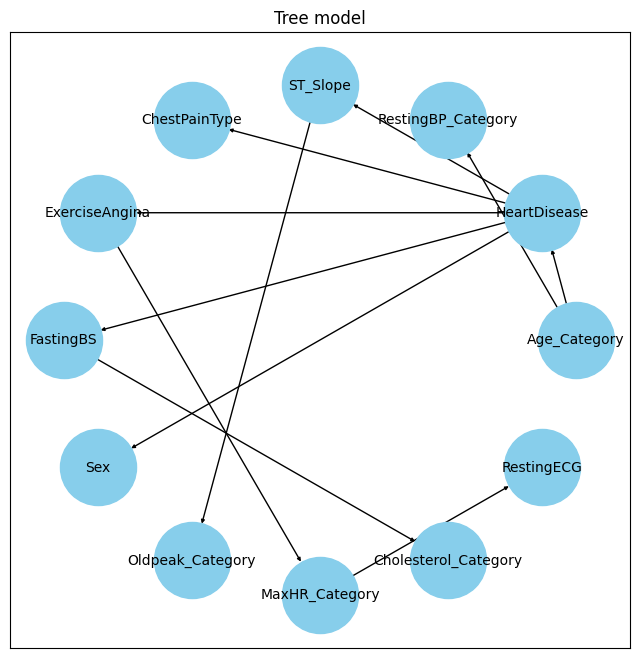

In [55]:
# Automatic model construction: Tree Search
ts = TreeSearch(data=train_data, root_node='Age_Category' ) # Age_Category - Sex
tree_model = ts.estimate(show_progress=False)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
nx.draw_networkx(tree_model, pos=nx.drawing.layout.circular_layout(tree_model), ax=ax, node_size=3000,
                     node_color='skyblue', font_size=10, arrows=True, arrowsize=5,)

plt.savefig(pathlib.Path.joinpath(project_dir,"out/tree.png"))
ax.set_title('Tree model')
tree_model = BayesianNetwork(tree_model.edges())

In [ ]:
# Automatic model construction: Hill Climb search using K2 score
scoring_method = K2Score(data=train_data)
hc = HillClimbSearch(data=train_data) 
hc_k2score_model = hc.estimate(scoring_method=scoring_method,
                               max_indegree=4, max_iter=int(1e4), show_progress=False,)

fig = plt.figure(figsize=(7, 7))
nx.draw(hc_k2score_model, with_labels=True, arrowsize=10, node_size=3000, node_color='skyblue', font_size=10, pos=nx.circular_layout(hc_k2score_model),)
plt.savefig(pathlib.Path.joinpath(project_dir, "out/hc_k2score_model.png"))

ax.set_title('HC base model')
hc_k2score_model = BayesianNetwork(hc_k2score_model.edges())

In [ ]:
# Automatic model construction: Hill Climb search using Bdeu score

fixed_edges = [('ChestPainType', 'HeartDisease'), ('Oldpeak_Category', 'HeartDisease'), 
               ('ST_Slope', 'HeartDisease'), ('ExerciseAngina', 'HeartDisease')]
black_list = [(f, 'Sex') for f in data.columns] 
black_list += [(f, 'Year') for f in data.columns]
black_list += [('FastingBS', 'HeartDisease')]



scorer = BDeuScore(data=train_data)
hc = HillClimbSearch(data=train_data)
hc_bdscore_model = hc.estimate(scoring_method=scorer, fixed_edges=fixed_edges, black_list=black_list, max_iter=int(1e4), show_progress=False)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
nx.draw_networkx(hc_bdscore_model, pos=nx.drawing.layout.circular_layout(hc_bdscore_model), ax=ax, node_size=3000,
                     node_color='skyblue', font_size=10, arrows=True, arrowsize=5)
plt.savefig(pathlib.Path.joinpath(project_dir,"out/hc_bdscore_model.png"))

ax.set_title('HC base model')
hc_bdscore_model = BayesianNetwork(hc_bdscore_model.edges())

In [ ]:
models = [('custom', heart_disease_model), ('tree', tree_model), 
          ('hc k2score', hc_k2score_model), ('hc bdscore', hc_bdscore_model)]

for name, model in models:
    print(f'Computing CPD (CPT) for {name} model')   # CPT per le variabili discrete, CPD è il concetto generale: descrive la dipendenza probabilistica P(Nodo | Genitori).
    model.fit(train_data, estimator=MaximumLikelihoodEstimator)
    """for cpd in model.get_cpds():
        print(cpd, "\n")
    print("- " * 40)"""

Computing CPD (CPT) for custom model


/media/leonardo/Data/Projects/FAIKR3/heart_failure_prediction_bayesian_reasoning/.venv/lib/python3.11/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/media/leonardo/Data/Projects/FAIKR3/heart_failure_prediction_bayesian_reasoning/.venv/lib/python3.11/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/media/leonardo/Data/Projects/FAIKR3/heart_failure_prediction_bayesian_reasoning/.venv/lib/python3.11/site-package

Computing CPD (CPT) for tree model


/media/leonardo/Data/Projects/FAIKR3/heart_failure_prediction_bayesian_reasoning/.venv/lib/python3.11/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/media/leonardo/Data/Projects/FAIKR3/heart_failure_prediction_bayesian_reasoning/.venv/lib/python3.11/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/media/leonardo/Data/Projects/FAIKR3/heart_failure_prediction_bayesian_reasoning/.venv/lib/python3.11/site-package

Computing CPD (CPT) for hc k2score model


/media/leonardo/Data/Projects/FAIKR3/heart_failure_prediction_bayesian_reasoning/.venv/lib/python3.11/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/media/leonardo/Data/Projects/FAIKR3/heart_failure_prediction_bayesian_reasoning/.venv/lib/python3.11/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/media/leonardo/Data/Projects/FAIKR3/heart_failure_prediction_bayesian_reasoning/.venv/lib/python3.11/site-package

Computing CPD (CPT) for hc bdscore model


/media/leonardo/Data/Projects/FAIKR3/heart_failure_prediction_bayesian_reasoning/.venv/lib/python3.11/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/media/leonardo/Data/Projects/FAIKR3/heart_failure_prediction_bayesian_reasoning/.venv/lib/python3.11/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/media/leonardo/Data/Projects/FAIKR3/heart_failure_prediction_bayesian_reasoning/.venv/lib/python3.11/site-package

##### Check the consistency of the models

In [59]:
for name, model in models:
    is_consistent = model.check_model()
    print(f"The model {name} is consistent: {is_consistent}")

The model custom is consistent: True
The model tree is consistent: True
The model hc k2score is consistent: True
The model hc bdscore is consistent: True


### Check independencies, Markov blankets

With pgmpy it is possible to analyse several different properties of the networks. For example, we can take a look at the different independencies which hold in the network, ask for the local semantics (any node in the network is independent of its non-descendents given its parents) for a set of nodes or ask for the Markov blanket of a certain node.

In [60]:
nodes = ['Sex', 'Age_Category', 'FastingBS', 'MaxHR_Category', 'ST_Slope', 'Cholesterol_Category', 'HeartDisease']
print('Considering nodes:', nodes)
for name, model in models:
    print(f'Analyzing model: {name}')
    print(f'The total number of valid independence assertions is {len(model.get_independencies().get_assertions())}')
    print(f'Local semantics of the current model:\n{model.local_independencies(nodes)}')
    print('Checking Markov blankets')
    for node in nodes:
        print(f'The Markov blanket of node {node} is {model.get_markov_blanket(node)}')
    print()

Considering nodes: ['Sex', 'Age_Category', 'FastingBS', 'MaxHR_Category', 'ST_Slope', 'Cholesterol_Category', 'HeartDisease']
Analyzing model: custom
The total number of valid independence assertions is 2822
Local semantics of the current model:
(Sex ⟂ Age_Category, FastingBS)
(Age_Category ⟂ Sex, ChestPainType)
(FastingBS ⟂ Sex, RestingBP_Category, Cholesterol_Category, ChestPainType | Age_Category)
(MaxHR_Category ⟂ RestingBP_Category, Cholesterol_Category, ChestPainType, FastingBS | Sex, Age_Category, RestingECG)
(ST_Slope ⟂ Sex, Age_Category, RestingBP_Category, Cholesterol_Category, ChestPainType, FastingBS | MaxHR_Category, ExerciseAngina, Oldpeak_Category, RestingECG)
(Cholesterol_Category ⟂ RestingBP_Category, ChestPainType, FastingBS | Sex, Age_Category)
(HeartDisease ⟂ Cholesterol_Category, FastingBS, RestingECG | MaxHR_Category, Oldpeak_Category, Sex, ST_Slope, ExerciseAngina, Age_Category, RestingBP_Category, ChestPainType)
Checking Markov blankets
The Markov blanket of nod

La Markov Blanket (MB) di HeartDisease è ['Oldpeak_Category', 'MaxHR_Category', 'ChestPainType', 'ST_Slope', 'Age_Category', 'Sex', 'RestingBP_Category', 'ExerciseAngina'].
Osservazione: Secondo questo specifico modello, queste 8 variabili sono l'insieme minimo sufficiente per predire HeartDisease. Tutte le altre variabili diventano irrilevanti per la predizione di HeartDisease una volta che conosciamo i valori di queste 8. Questo è un risultato diretto e potente per la feature selection basata su questo modello.


qualsiasi influenza che RestingECG, Cholesterol_Category e FastingBS possono avere su HeartDisease è completamente mediata dalle variabili presenti nella MB. Non aggiungono informazione predittiva diretta su HeartDisease se la MB è già nota.


Cholesterol_Category e FastingBS  

In [61]:
inferences = [(name, VariableElimination(model)) for name, model in models]

#### Query 1: Heart Disease prediction on Age and Sex

$$P(\text{HeartDisease} | \text{Age\_Category} = 2, \text{Sex} = 1)$$


In [62]:
print(inferences[0][1].query(["HeartDisease"], evidence={'Age_Category': 2, 'Sex': 1}))


+-----------------+---------------------+
| HeartDisease    |   phi(HeartDisease) |
+=================+=====================+
| HeartDisease(0) |              0.3725 |
+-----------------+---------------------+
| HeartDisease(1) |              0.6275 |
+-----------------+---------------------+


Performing inference for model: custom
Performing inference for model: tree
Performing inference for model: hc k2score
Performing inference for model: hc bdscore


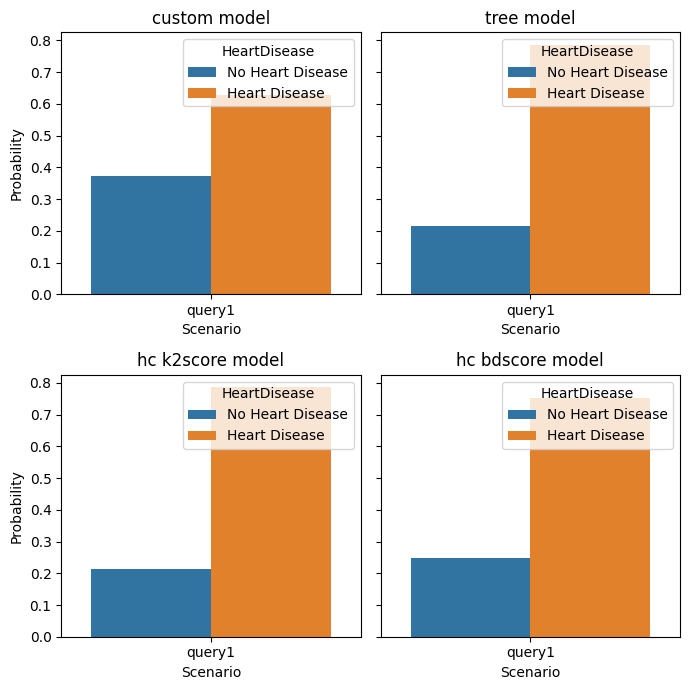

In [63]:
evidence = {'Age_Category': 2, 'Sex': 1}
results_query1 = {}
for name, inference in inferences:
    results_query1[name] = {}
    print(f"Performing inference for model: {name}")
    results_query1[name]['query1'] = inference.query(["HeartDisease"], evidence, show_progress=False).values

plot_values(results_query1, label_map={0: 'No Heart Disease', 1: 'Heart Disease'})

### Query 2: Which Chest pain type cause a high risk of Heart disease in an male Adult patient?

$$P(\text{HeartDisease} | \text{Age\_Category} = 2, \text{Sex} = 1, \text{ST\_Slope} = 1)$$


In [64]:
print(inferences[0][1].query(["HeartDisease"], evidence={'Age_Category': 2, 'Sex': 1, "ST_Slope": 1}))

+-----------------+---------------------+
| HeartDisease    |   phi(HeartDisease) |
+=================+=====================+
| HeartDisease(0) |              0.2086 |
+-----------------+---------------------+
| HeartDisease(1) |              0.7914 |
+-----------------+---------------------+


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

Scenario: ST_Slope of an old male man
Possible pain type: [0, 1, 2]
Performing inference for model: custom
Performing inference for model: tree
Performing inference for model: hc k2score
Performing inference for model: hc bdscore


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


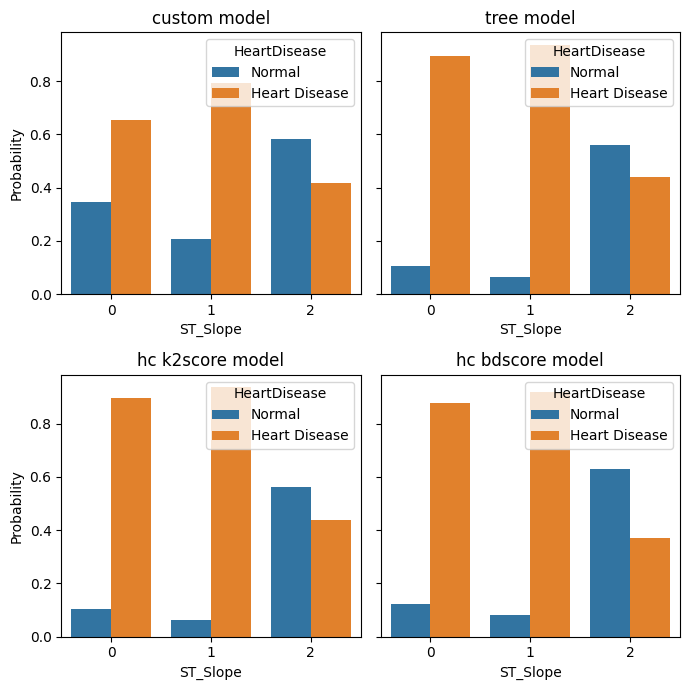

In [65]:
synthom = "ST_Slope"

pain_types = [0, 1, 2] # [Down: 0, Flat: 1, Up: 2]
answer_pain_types = {}
evidence = {"Age_Category": 2, "Sex": 1}
print(f"Scenario: {synthom} of an old male man")
print(f"Possible pain type: {pain_types}")
for name, inference in inferences:
    answer_pain_types[name] = {}
    print(f"Performing inference for model: {name}")
    for pain_type in pain_types:
        evidence[synthom] = pain_type
        answer_pain_types[name][pain_type] = inference.query(["HeartDisease"], evidence, show_progress=False).values

plot_values(answer_pain_types, label_map={0: 'Normal', 1: 'Heart Disease'}, x=synthom, state_col='HeartDisease', y='Probability')
            


Results show Flat and Downsloping ST segment patterns are most associated with Heart Disease, aligning with clinical findings.
- Flat slope: Indicates myocardial ischemia and increased cardiovascular risk.
- Downsloping slope: Strongly suggests more severe ischemia and carries a bad prognosis.

$$P(\text{HeartDisease} | \text{Age\_Category} = 0, \text{ChestPainType} = 0)$$

In [66]:
print(inferences[0][1].query(["HeartDisease"], evidence={'Age_Category': 0, 'ChestPainType': 0}))

+-----------------+---------------------+
| HeartDisease    |   phi(HeartDisease) |
+=================+=====================+
| HeartDisease(0) |              0.3637 |
+-----------------+---------------------+
| HeartDisease(1) |              0.6363 |
+-----------------+---------------------+


Scenarios: probability following the pairs of Age_Category/ChestPainType 
[(0, 0), (0, 1), (0, 2), (0, 3)]
Performing inference for model: custom
Performing inference for model: tree
Performing inference for model: hc k2score
Performing inference for model: hc bdscore


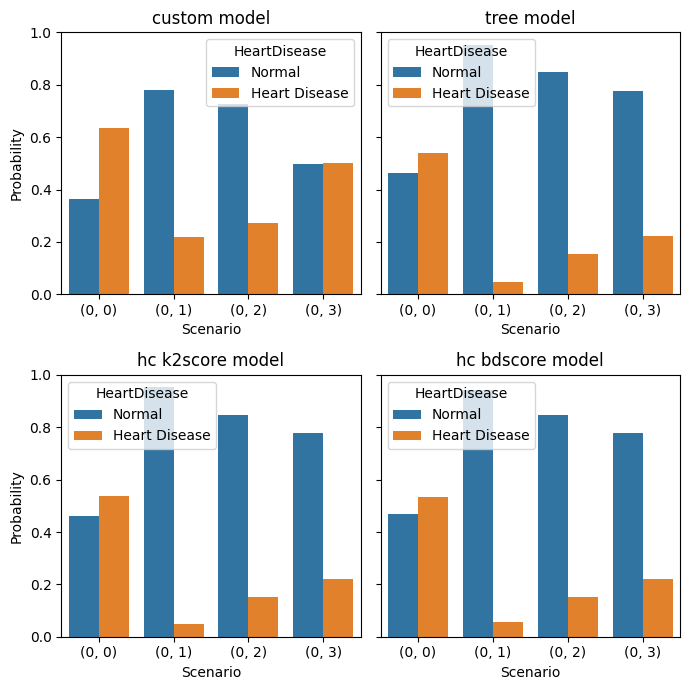

In [67]:
#### Query 3: Heart Disease risk by age and chest pain type

age = 0
values = [(age, 0), (age, 1), (age, 2), (age, 3)] #'ASY' → 0 'ATA' → 1 'NAP' → 2 'TA' → 3
answer_values = {}
print(f"Scenarios: probability following the pairs of Age_Category/ChestPainType \n{values}")
for name, inference in inferences:
    print(f"Performing inference for model: {name}")
    answer_values[name] = {}
    for age, chest_pain_type in values:
        evidence = {"Age_Category": age, "ChestPainType": chest_pain_type}
        answer_values[name][(age, chest_pain_type)] = inference.query(["HeartDisease"], evidence, show_progress=False).values
plot_values(answer_values, label_map={0: 'Normal', 1: 'Heart Disease'})

Results confirms ASY (Asymptomatic) and TA (Typical Angina) are most linked  to Heart Disease in this data.

TA is the classic symptom; 
ASY reflects the known danger of silent/late-diagnosed disease (high risk despite no typical pain).

The probability is now in favor of Asymptomatic and Typical Angina. So we can deduce that this two factors has some influence in heart disease. 
Let's see the full spectrum now:

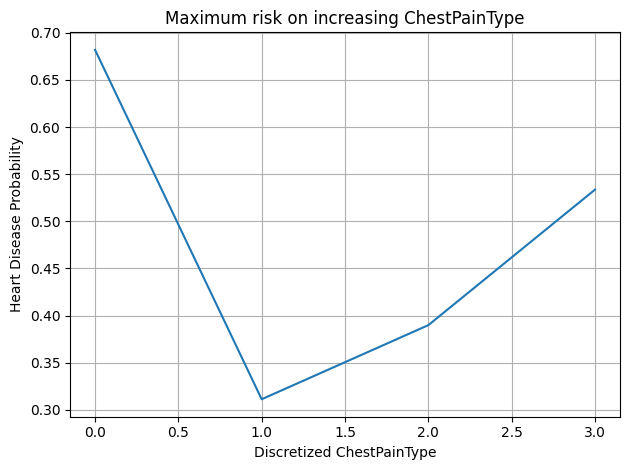

In [68]:
from pgmpy.factors.discrete import State

exact_inference = inferences[0][1] #custom model
illness = "ChestPainType"

heart_disease = []
predictions_list = []
for t in range(data[illness].max() + 1):
    evidence = [State(illness, t)]
    prob = exact_inference.query(["HeartDisease"], evidence=dict(evidence), show_progress=False)
    heart_disease.append(prob.values[-1])

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(range(len(heart_disease)), heart_disease)
plt.title(f"Maximum risk on increasing {illness}")
plt.xlabel(f"Discretized {illness}")
plt.ylabel("Heart Disease Probability")
plt.grid()
plt.tight_layout()
plt.savefig(pathlib.Path.joinpath(project_dir,"out/inc_temp.png"))
plt.show()

### Let's see our model outcomes

### Performance test

In [69]:
iter = 10000
evidence = {'Age_Category': 2, 'Sex': 1}

for name, inference in inferences:
    start_time = time.time()
    for i in range(iter):
        inference.query(["HeartDisease"], evidence, show_progress=False).values
    end_time = time.time()
    elapsed_time = (end_time - start_time) / iter
    print(f"Elapsed time for {name}: ", elapsed_time, "seconds")

Elapsed time for custom:  0.0014278611660003661 seconds
Elapsed time for tree:  0.00026357619762420656 seconds
Elapsed time for hc k2score:  0.0005436386346817017 seconds
Elapsed time for hc bdscore:  0.0006999753713607789 seconds
